Согласно легенде хакатона, в контакт с Землёй вошла инопланетная цивилизация, попросившая у земных дата-сайентистов помощи в выполнении следующих задач:
1. Создать алгоритм, предсказывающий Индекс Благосостояния (Index) галактик на основе их социо-экономических характеристик
2. Распределить доступные ресурсы (extra energy) между галактиками оптимальным образом при соблюдении следующих условий:
    * Имеется 50000 единиц extra energy
    * Потенциал каждой галактики к увеличению благосостояния = -np.log(Index+0.01)+3
    * Вероятное увеличение благосостояния = extra energy * Potential for increase in the Index **2 / 1000
    * Каждая галактика должна получить не менее 0 и не более 100 extra energy.
    * Галактики с параметром existance expectancy index < 0.7 должны получить не менее 10% от всей доступной extra energy

## Задачи:
1. Осуществить разведочный анализ данных, удалить сильно скореллированные переменные
2. Предсказать с помощью линейной регрессии значение зависимой переменной ("Благосостояние")
3. Найти оптимальное распределение благосостояния между галактиками с помощью линейного программирования

### Импортируем нужные библиотеки и данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats

In [2]:
train = pd.read_csv('D:/prohack/train.csv') # загружаем обучающую выборку
test = pd.read_csv('D:/prohack/test.csv') # загружаем тестовую выборку

In [3]:
train.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,NaN,NaN,NaN,NaN,NaN,19.177926,NaN,22.785018,NaN,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,NaN,NaN,NaN,NaN,NaN,21.151265,6.534020,NaN,NaN,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.912194,NaN,NaN,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,...,NaN,NaN,NaN,NaN,NaN,NaN,5.611753,NaN,NaN,0.154247


In [4]:
train.shape

(3865, 80)

In [5]:
#train.info()

### Определим, какие переменные будут включены в модель

**Оставим только переменные, содержащие более 3000 значений**

In [6]:
train_subset1 = train[['galactic year', 'galaxy', 'existence expectancy index', 'existence expectancy at birth',
                       'Gross income per capita', 'Income Index', 'Expected years of education (galactic years)',
                       'Mean years of education (galactic years)', 'Intergalactic Development Index (IDI)', 'Education Index',
                       'Intergalactic Development Index (IDI), Rank', 'y']]

In [7]:
train_subset1.shape

(3865, 12)

**Визуализируем корреляционную матрицу выбранных переменных**

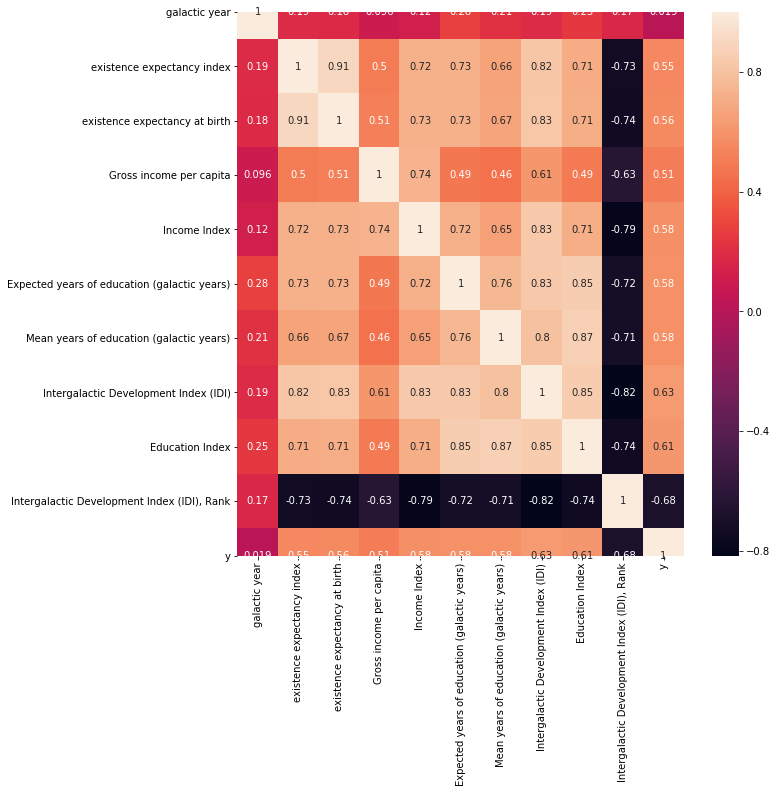

In [8]:
plt.subplots(figsize = (10, 10))
sns.heatmap(train_subset1.corr(), xticklabels = True, yticklabels = True, annot = True)

**Включим в модель следующие переменные:**  
'galactic year', 'galaxy', 'existence expectancy index', 'Gross income per capita', 'Mean years of education (galactic years)', 'Intergalactic Development Index (IDI)', 'y'

### Предобработка данных

In [9]:
train_reduced = train[['galactic year', 'galaxy', 'existence expectancy index', 'Gross income per capita', 
                       'Mean years of education (galactic years)', 'Intergalactic Development Index (IDI)', 'y']]

In [10]:
train_reduced.shape

(3865, 7)

**Заполним пропущенные значения средним по столбцу**

In [11]:
train_filled = train_reduced.fillna(train_reduced.mean())

In [12]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 7 columns):
galactic year                               3865 non-null int64
galaxy                                      3865 non-null object
existence expectancy index                  3865 non-null float64
Gross income per capita                     3865 non-null float64
Mean years of education (galactic years)    3865 non-null float64
Intergalactic Development Index (IDI)       3865 non-null float64
y                                           3865 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 211.5+ KB


**Нормализуем наши переменные**

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
X = train_filled.iloc[:, 2:6]

In [16]:
X_scaled = scaler.fit_transform(X)

### Обучим модель

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
y = train_filled.y

In [19]:
model = LinearRegression().fit(X_scaled, y)

### Подготовим тестовую выборку

In [20]:
test_reduced = test[['galactic year', 'galaxy', 'existence expectancy index', 'Gross income per capita', 
                       'Mean years of education (galactic years)', 'Intergalactic Development Index (IDI)']]

In [21]:
test_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 6 columns):
galactic year                               890 non-null int64
galaxy                                      890 non-null object
existence expectancy index                  885 non-null float64
Gross income per capita                     885 non-null float64
Mean years of education (galactic years)    882 non-null float64
Intergalactic Development Index (IDI)       882 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 41.8+ KB


In [22]:
test_filled = test_reduced.fillna(test_reduced.mean()) # заполняем пропущенные значения средним по столбцу

In [23]:
test_filled.head()

,galactic year,galaxy,existence expectancy index,Gross income per capita,Mean years of education (galactic years),Intergalactic Development Index (IDI)
0,1007012,KK98 77,0.456086,12236.576447,10.699072,0.547114
1,1007012,Reticulum III,0.529835,3431.883825,5.311122,0.497688
2,1008016,Reticulum III,0.560976,27562.914252,5.937797,0.544744
3,1007012,Segue 1,0.565910,20352.232905,10.067882,0.691641
4,1013042,Virgo I,0.588274,23959.704016,6.374637,0.530676


In [24]:
X_test = test_filled.iloc[:, 2:6]

In [25]:
X_test_scaled = scaler.fit_transform(X_test)

### Получим предсказания благосостояния

In [26]:
predictions = model.predict(X_test_scaled)

### Найдём оптимальный способ распределить дополнительную энергию между галактиками

**Необходимо выполнить следующие условия:**  
$X = \{x_1, x_2, ..., x_{890}\}$  
$Z = \{z_1, z_2, ..., z_n\} \subset X$  
$x_1 + x_2 + ... + x_{890} <= 50000$  
$z_1 + z_2 + ... + z_n >= 5000$  
$0 <=  x_i <= 100$  
$max \sum_{n=1}^{890} x_i * ((-\ln(Index_i + 0.01)) + 3)^{2/1000}$  
Где:  
X: множество, включающее в себя долю дополнительных ресурсов для каждой галактики  
Z: множество галактик с параметром existance expectancy index < 0.7

In [27]:
poor = list(test_filled[test_filled['existence expectancy index'] < 0.7].index) # номера бедных галактик

**Создадим два вектора - коэффициенты для уравнений:**  
$x_1 + x_2 + ... + x_{890} <= 50000$  
$-z_1 - z_2 - ... - z_n >= -5000$  

In [28]:
A_sum = [1.]*890 # вектор из единиц для первого уравнения

In [29]:
vec_ineq = []
for i in range(0, 890):
    if i in poor:
        vec_ineq.append(-1.)
    else:
        vec_ineq.append(0.)

In [30]:
A_ineq = vec_ineq # вектор из минус единиц для второго уравнения

**Создадим целевую функцию:**  
$max \sum_{n=1}^{890} x_i * ((-\ln(Index_i + 0.01)) + 3)^{2/1000}$  

In [31]:
cost_func = [] # так как np.log не может работать с отрицательными числами, заменим их нулями
for i in predictions:
    if i >= 0:
        potential = -np.log(i + 0.01) + 3
        likely_increase = -((potential**2) / 1000)
        cost_func.append(likely_increase)
    elif i < 0:
        potential0 = -np.log(0 + 0.01) + 3
        likely_increase0 = -((potential0**2) / 1000)
        cost_func.append(likely_increase0)

In [32]:
A_total = [A_sum, A_ineq] # объединяем вектора в матрицу

**Найдём оптимальное разбиение с помощью функции scipy.optimize.linprog**

In [33]:
opt = scipy.optimize.linprog(c = cost_func, A_ub = A_total, b_ub = [50000., -5000.], bounds = (0, 100),
                              method = 'interior-point')

In [34]:
max(opt.x)

99.99996726109316

In [35]:
min(opt.x)

8.875721881633439e-05

In [36]:
sum(opt.x)

49999.99913081229

### Результаты

**Экспортируем результаты в CSV**

In [37]:
results = pd.DataFrame({'pred': predictions, 'opt_pred' : opt.x})

In [38]:
results.to_csv('D:/prohack/submit.csv', float_format = '%.15f')